# MODULE

In [12]:
bool('')

False

In [19]:
orig = '/Users/tessa/Code/detect-towhee/myfile.wav'
suffix = 'detecc'
subdir = 'test_dir_making'

filesplit = os.path.split(orig)
base_path = filesplit[0]
file_name = filesplit[1]
base_name = f'{os.path.splitext(file_name)[0]}_{suffix}.wav'
if subdir:
    base_path = os.path.join(base_path, subdir)
    try: 
        os.mkdir(base_path)
    except FileExistsError:
        pass
file_path = os.path.join(base_path, base_name)

In [20]:
file_path

'/Users/tessa/Code/detect-towhee/test_dir_making/myfile_detecc.wav'

In [11]:
new_full

'/Users/tessa/Code/detect-towhee/test_detections.wav'

In [1]:
%%bash
pwd

/Users/tessa/Code/detect-towhee


In [1]:
from squiggle_detector import *

/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Make spectrogram

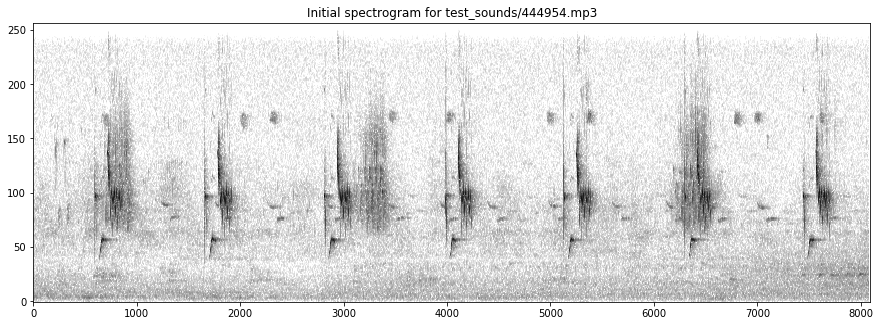

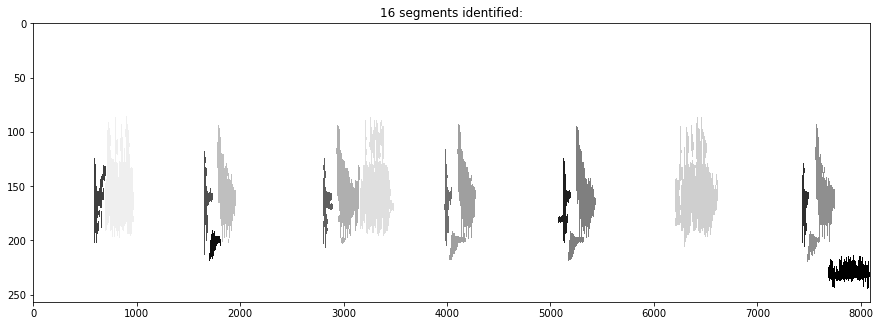

444954


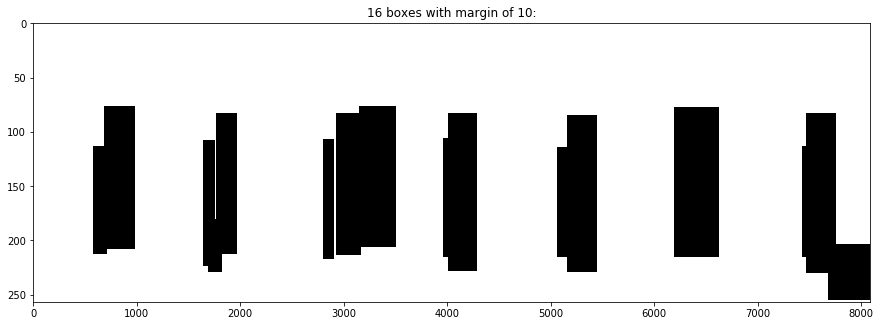

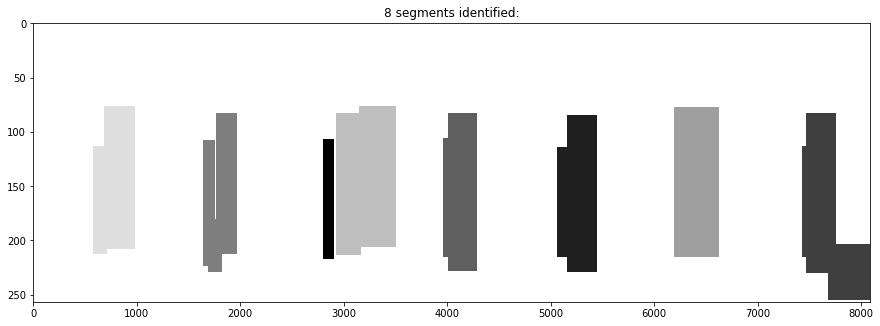

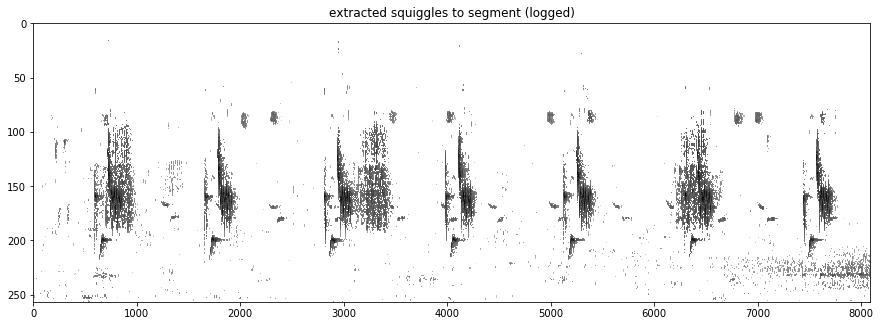

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log


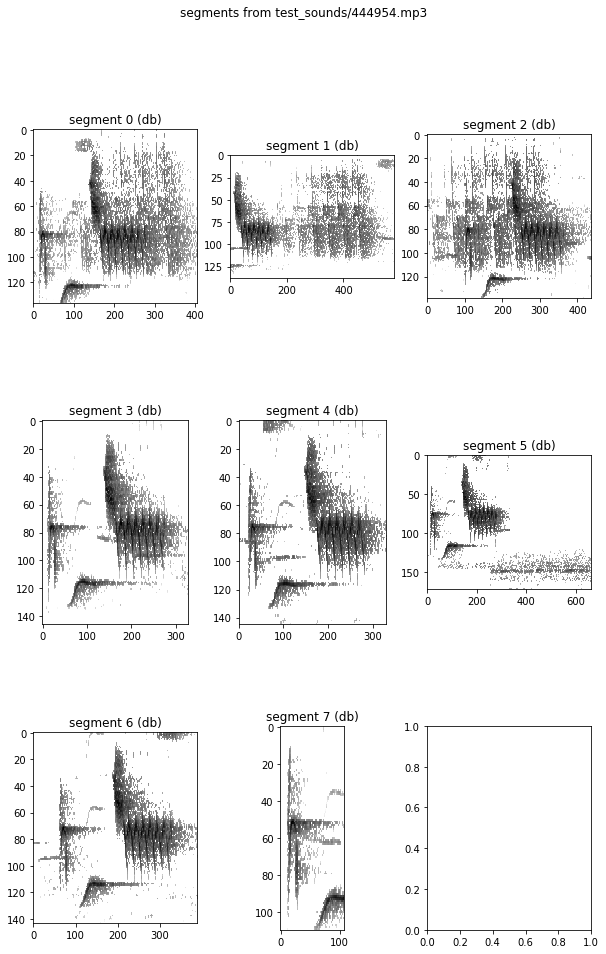

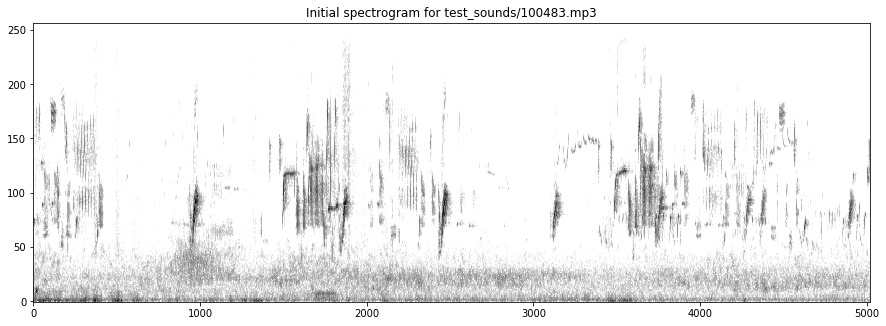

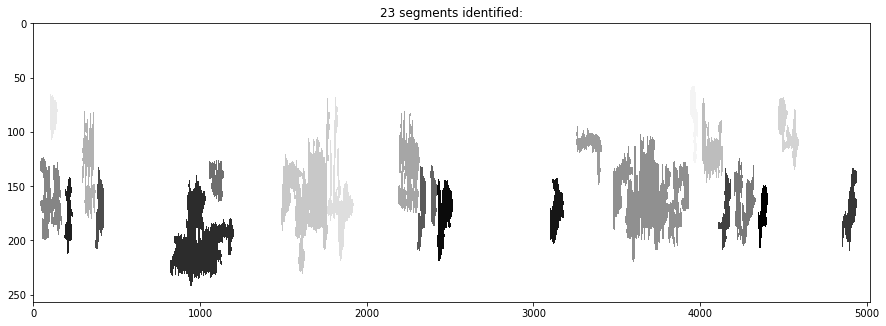

100483


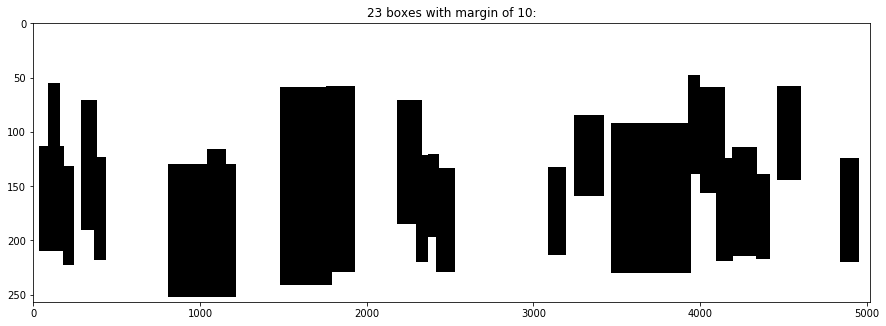

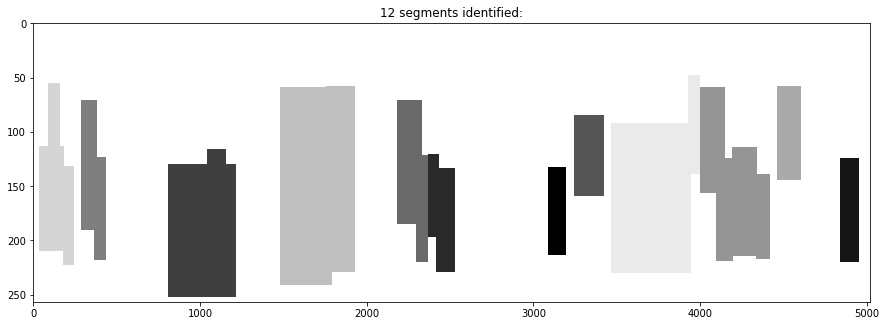

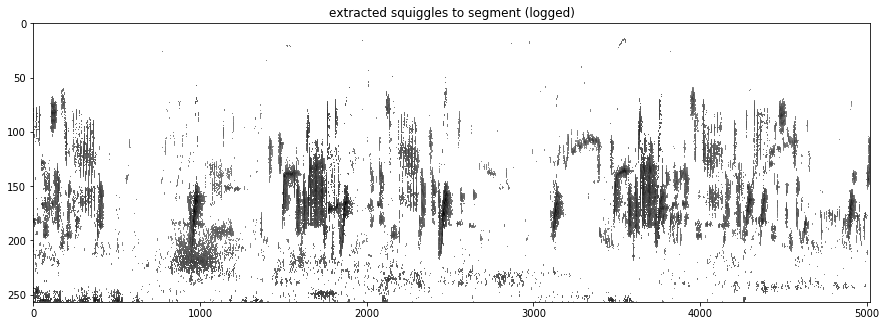

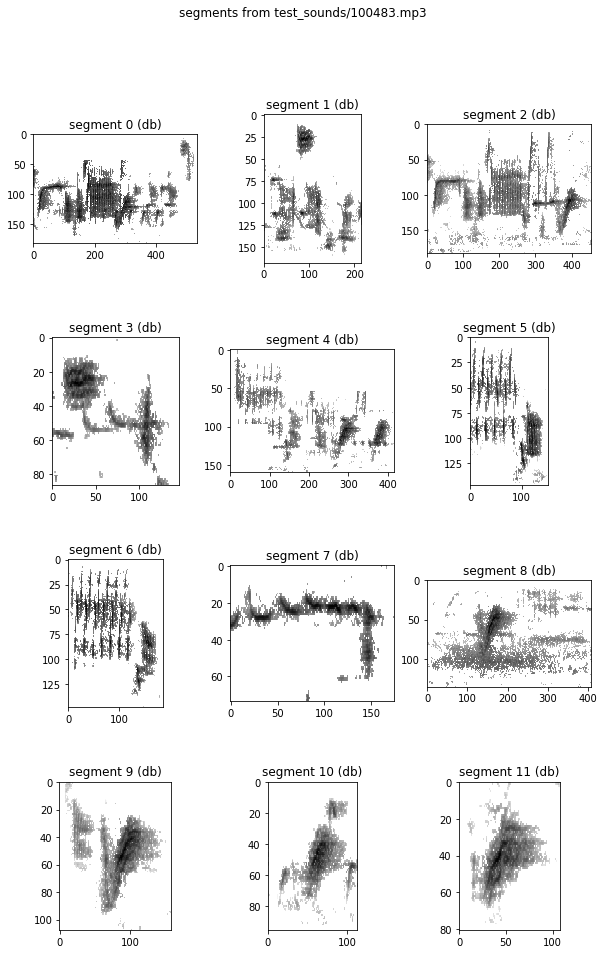

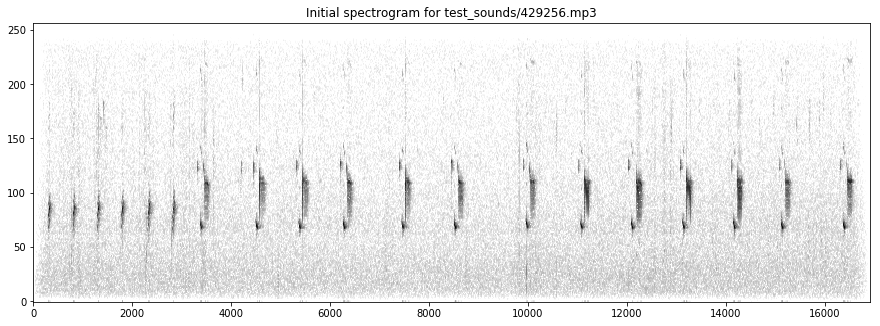

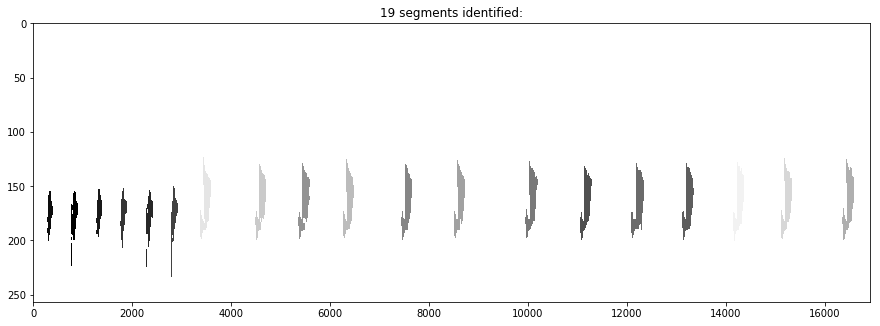

429256


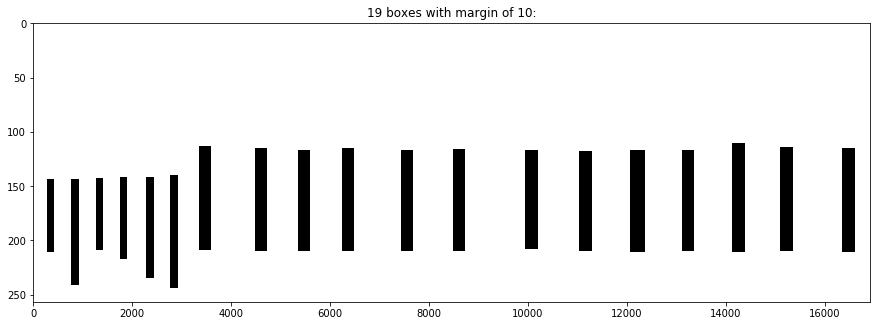

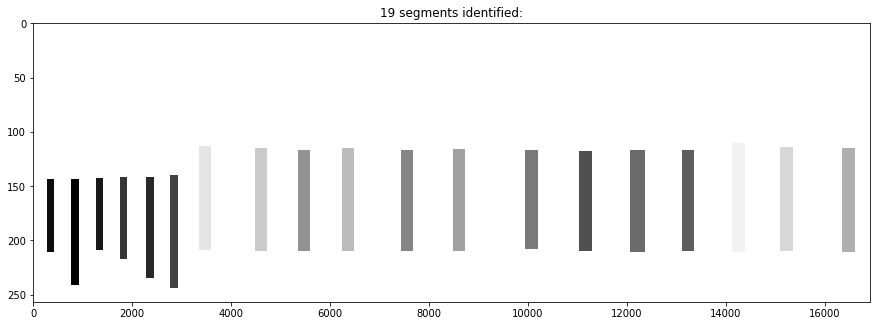

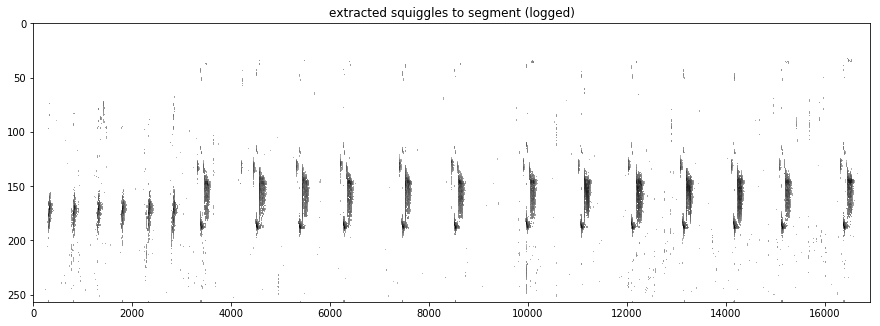

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


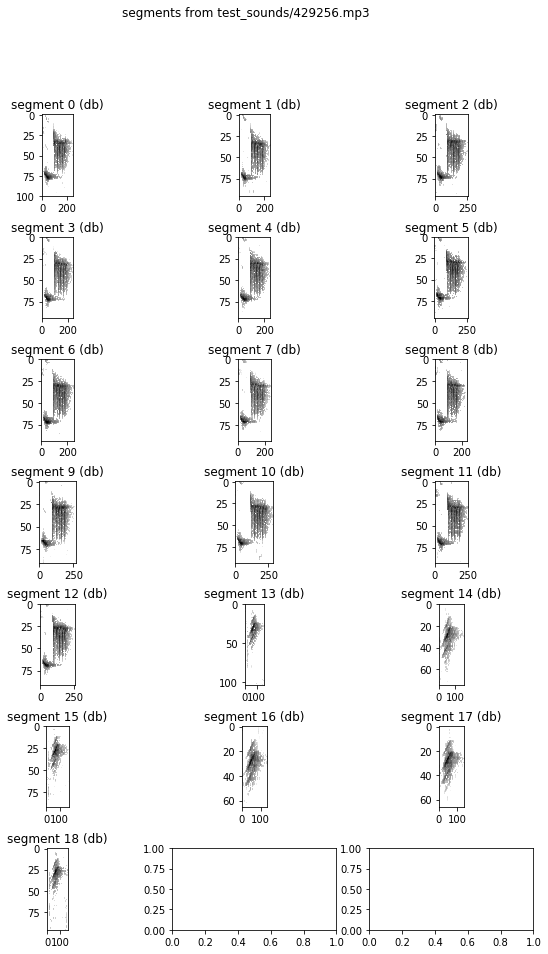

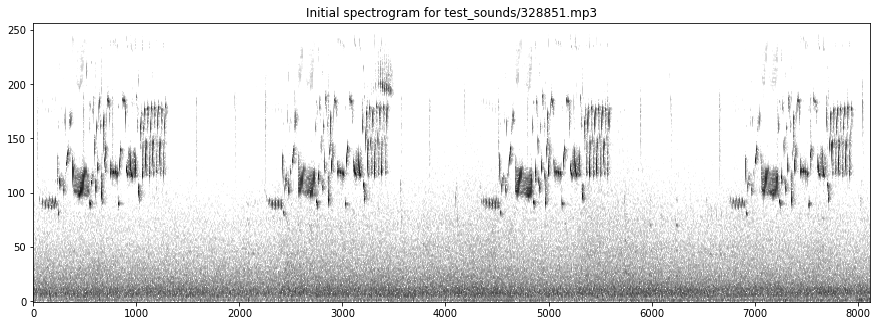

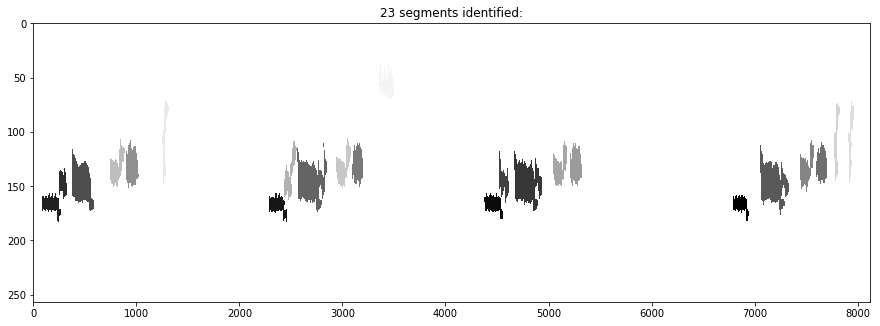

328851


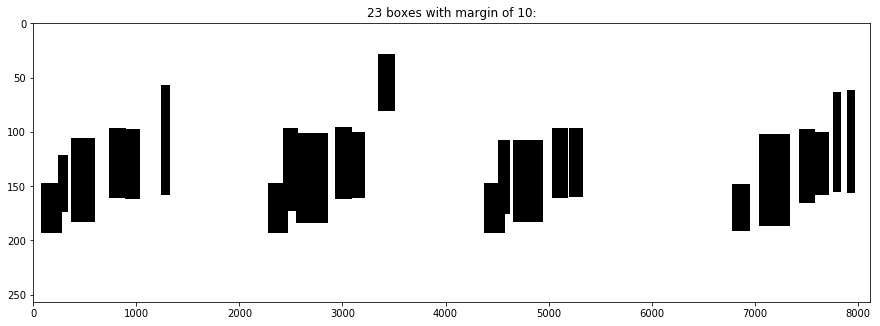

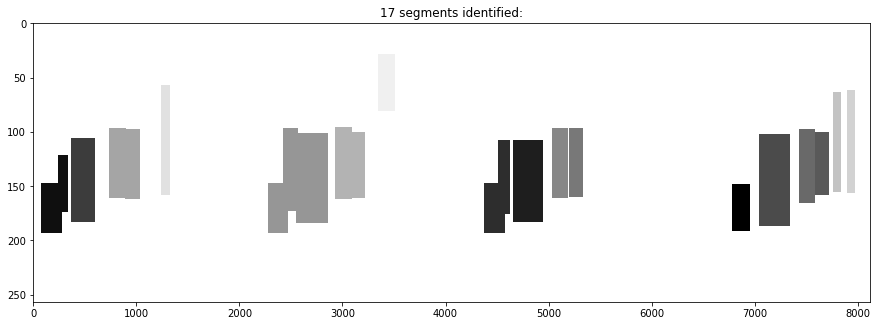

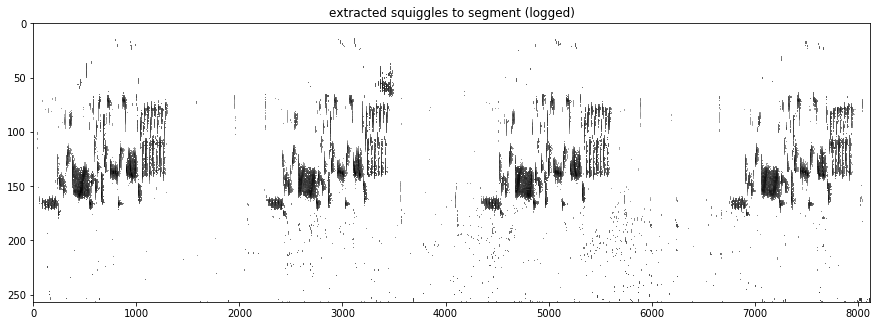

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log


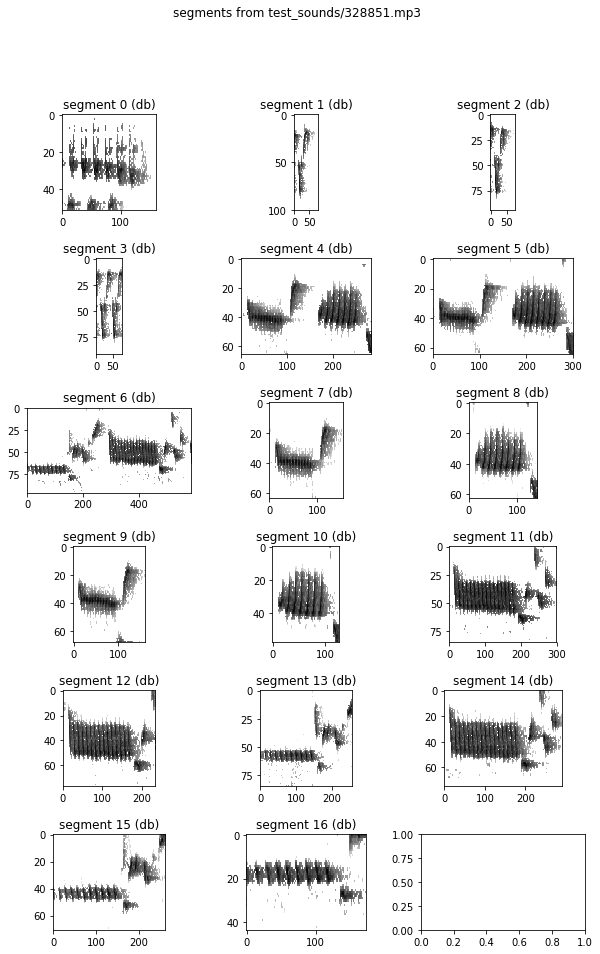

In [5]:
from collections import OrderedDict

filenames = ['test_sounds/444954.mp3', 'test_sounds/100483.mp3','test_sounds/429256.mp3','test_sounds/328851.mp3',]
samples_per_seg = 512
overlap_percent = 0.75
sample_rate = 22050.0

filename = filenames[0]
segs_dict = {}

for filename in filenames:
    # Load file
    samples, sample_rate = load_file(
        filename = filename,
        sample_rate = sample_rate)

    # Make spectrogram
    freqs, times, spect = make_spect(
        samples = samples,
        samples_per_seg = samples_per_seg,
        overlap_percent = overlap_percent,
        sample_rate = sample_rate)
    plotter(spect, upside_down=True, title=f'Initial spectrogram for {filename}', db=True)

    # Remove undesired frequencies
    #low_frequency_thresh = 173
    #high_frequency_thresh = 10033
    #spect, f = spectrogram_bandpass(spect, f, low_frequency_thresh, high_frequency_thresh)
    #plotter(power_to_db(spect), upside_down=True)

    # Normalize spectrogram
    normalized_spect = normalize_spect(spect)

    # Binarize by median filtering
    median_binarize_multiplier = 9.0
    binary_spect = binarize_by_median(normalized_spect, multiplier = median_binarize_multiplier)
    
    # Image processing noise reduction
    small_obj_size = 1000.0
    binary_closing_size = (5, 5)
    binary_dilation_size = (3, 5)
    desired_steps = OrderedDict({
        'small_objects':small_obj_size,
        'binary_closing':binary_closing_size,
        'binary_dilation':binary_dilation_size
    })
    binary_processed = image_processing_dict( 
        spectrogram = binary_spect,
        params = desired_steps
        #plot_func = plotter
    )

    # Find bounding boxes in processed spect
    bounding_boxes = box_binary(binary_processed)

    # Use bounding boxes to save a noise file
    noise_filename = save_noise_file(
        binary_spectrogram=binary_processed,
        bounding_boxes=bounding_boxes,
        original_filename=filename,
        samples = samples,
        freqs = freqs,
        times = times,
        sr = sample_rate)

    # Noise-reduce the samples
    samples_nr = audacity_noise_reduce(noise_file=noise_filename, audio_samples=samples)
    freqs_nr, times_nr, spect_nr = make_spect(samples_nr, samples_per_seg=samples_per_seg, overlap_percent=overlap_percent)
    spect_nr = normalize_spect(spect_nr)
    #plotter(spect_nr, db=True, title='noise-reduced')

    # Save denoised sound file
    subdir = os.path.splitext(os.path.basename(filename))[0]
    wav_writer(samples = samples_nr, sample_rate=sample_rate, suffix='denoised', orig=filename, subdir=subdir)
    
    # If using Audacity noise reduction and binary_spect was not made from 
    # the noise-reduced spectrogram, it will be slightly larger than the 
    # noise-reduced spect. Make them the same size by just selecting the 
    # first part of the binary_spect:
    if spect_nr.shape != binary_spect.shape:
        shape_difference = np.subtract(spect_nr.shape, binary_spect.shape)
        new_dims = np.add(binary_spect.shape, shape_difference)
        # TODO: centering this might work better than just taking the beginning
        binary_spect_to_use = binary_spect[0:new_dims[0], 0:new_dims[1]]
    else:
        binary_spect_to_use = binary_spect
    segs = identify_segments(spect_nr, binary_spect_to_use, bounding_boxes, plot_func=plotter, margin = 10)#, method='min')
    
    # Save samples
    for idx, box in enumerate(bounding_boxes):
        # convert box, which is in terms of numpy array, to sample number and frequency number
        high_freq, low_freq, start_sample, end_sample = box_to_ft(box, freqs_nr, times, sample_rate) #Note: times_nr results in out of bounds

        # extract those samples from the audio
        segment_samples = samples_nr[start_sample: end_sample]

        # bandpass filter the samples above and below the box limits
        filtered_samples = butter_bandpass_filter(segment_samples, low_freq, high_freq, sample_rate)

        # save samples
        wav_writer(filtered_samples, sample_rate, f'detection{idx}', orig=filename, subdir=subdir)
    
    
    # save for later so that we could plot them in different ways if desired
    segs_dict[filename] = segs
    
    num_segs = len(segs)
    num_cols = 3
    num_rows = int(np.ceil(num_segs/num_cols))
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 15))
    ordered_axes = []
    for ax1 in range(ax.shape[0]):
        for ax2 in range(ax.shape[1]):
            ordered_axes.append(ax[ax1][ax2])
    for idx, axis in enumerate(ordered_axes):
        if idx >= len(segs):
            break
        axis.imshow(np.log(cropper(segs[idx])), cmap=plt.get_cmap("gray_r"))
        axis.set_title(f'segment {idx} (db)')
        axis.set_aspect(segs[idx].shape[1] / (10*segs[idx].shape[0]))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(f'segments from {filename}')

# Example modified plotting

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


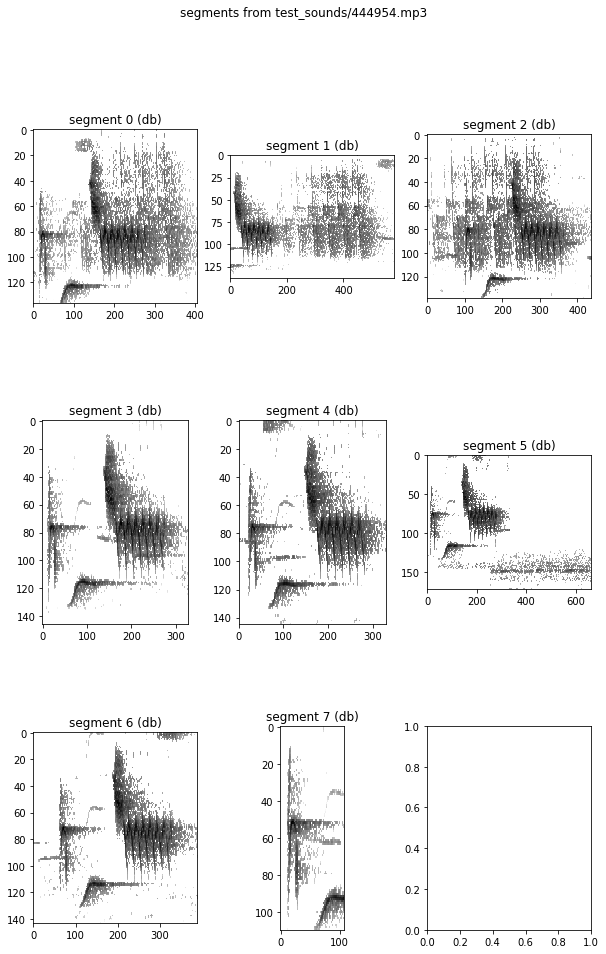

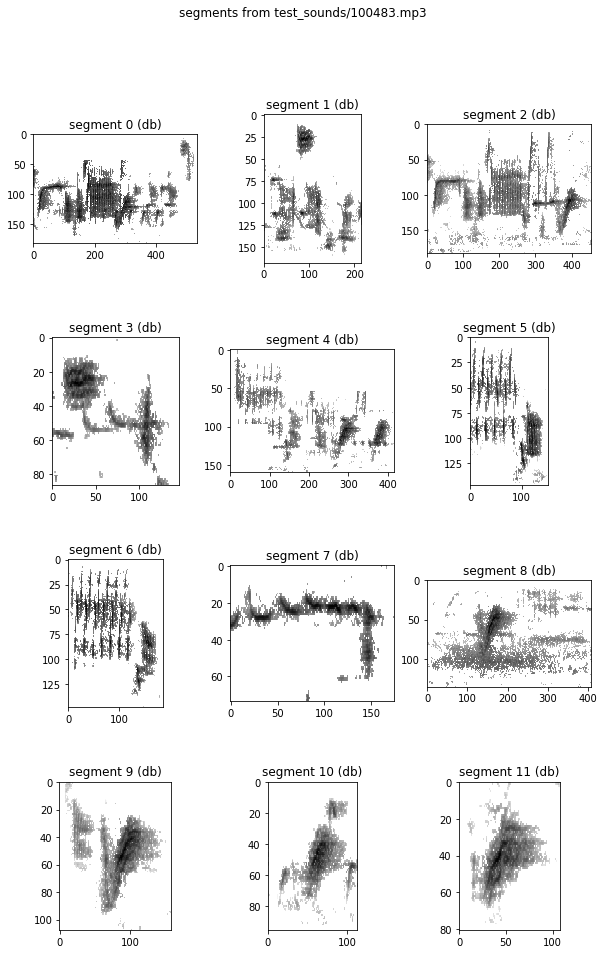

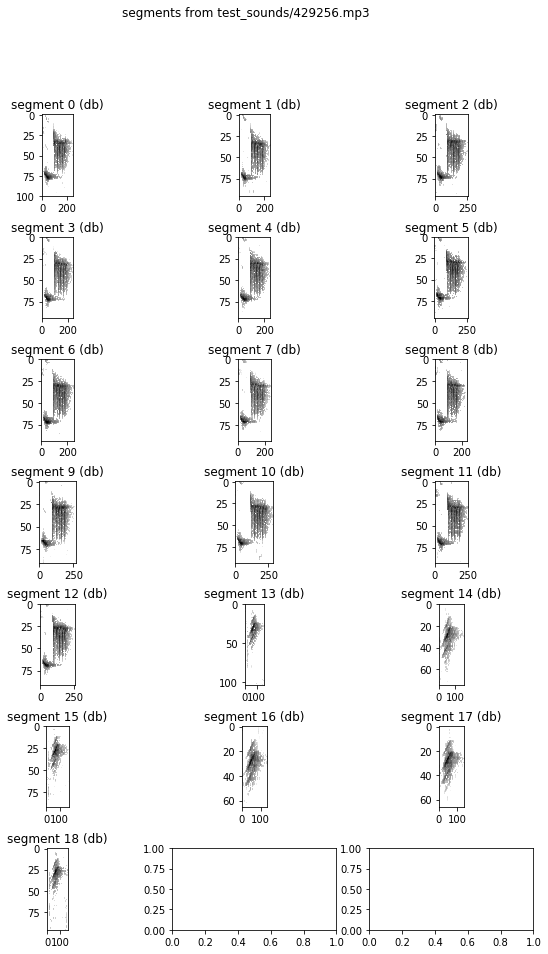

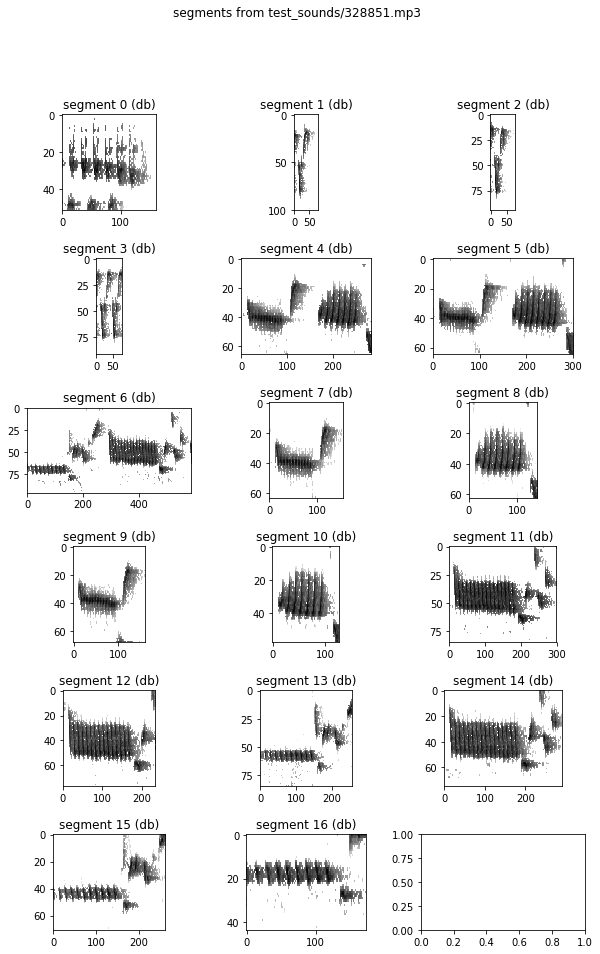

In [37]:


for key in segs_dict.keys():
    segs = segs_dict[key]
    num_segs = len(segs)
    num_cols = 3
    num_rows = int(np.ceil(num_segs/num_cols))
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 15))
    ordered_axes = []
    for ax1 in range(ax.shape[0]):
        for ax2 in range(ax.shape[1]):
            ordered_axes.append(ax[ax1][ax2])
    for idx, axis in enumerate(ordered_axes):
        if idx >= len(segs):
            break
        axis.imshow(np.log(cropper(segs[idx])), cmap=plt.get_cmap("gray_r"))
        axis.set_title(f'segment {idx} (db)')
        axis.set_aspect(segs[idx].shape[1] / (10*segs[idx].shape[0]))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(f'segments from {key}')